In [1]:
import pandas as pd
import os
import numpy as np
import random
import glob
from huggingface_hub import snapshot_download
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

/home/hubert/PycharmProjects/BestHackingLeague/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Wczytanie danych

In [ ]:
# # 1. Download dataset repo
# local_dir = snapshot_download(
#     repo_id="ejhusom/llm-inference-energy-consumption",
#     repo_type="dataset",
# )
#
# # 2. Point to folder with CSVs
# data_dir = os.path.join(local_dir, "data")
#
# # 3. Read and label each CSV
# dfs = []
# for path in glob.glob(os.path.join(data_dir, "*.csv")):
#     fname = os.path.basename(path)
#     print("Reading:", fname)
#
#     # infer label: laptop or workstation
#     if "laptop1" in fname.lower():
#         device_type = "laptop1"
#     if "laptop2" in fname.lower():
#         device_type = "laptop2"
#     elif "workstation" in fname.lower():
#         device_type = "workstation"
#     elif "server" in fname.lower():
#         device_type = "server"
#     else:
#         device_type = "unknown"
#
#     df = pd.read_csv(path)
#     df["device_type"] = device_type   # add as a new column
#     dfs.append(df)
#
# # 4. Merge all CSVs
# full_df = pd.concat(dfs, ignore_index=True)
#
# # 5. Save merged version
# if not os.path.exists("data"):
#     os.mkdir("data")
# full_df.to_csv(os.path.join("data", "llm_inference_energy.csv"), index=False)
#
# print("✅ Combined shape:", full_df.shape)
# print("✅ Unique device types:", full_df["device_type"].unique())

In [2]:
data = pd.read_csv(os.path.join("data/llm_inference_energy.csv"))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78728 entries, 0 to 78727
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0.2                   10694 non-null  float64
 1   Unnamed: 0.1                   32283 non-null  float64
 2   Unnamed: 0                     78728 non-null  int64  
 3   index                          78728 non-null  int64  
 4   model_name                     78728 non-null  object 
 5   created_at                     78728 non-null  object 
 6   total_duration                 78690 non-null  float64
 7   load_duration                  78690 non-null  float64
 8   prompt_token_length            78425 non-null  float64
 9   prompt_duration                78690 non-null  float64
 10  response_token_length          78690 non-null  float64
 11  response_duration              78690 non-null  float64
 12  prompt                         78728 non-null 

More spec columns

In [3]:
device_specs = {
    "server": {
        "cpu_vendor": "AMD",
        "cpu_family": "EPYC 7643",
        "cpu_cores": 48,
        "cpu_base_clock_ghz": np.nan,  # unknown from your string; fill later if needed
        "ram_gb": 528,
        "has_gpu": 1,
        "gpu_model": "RTX A5000",
        "gpu_vram_gb": 24,
        "gpu_class": "pro",
        "device_family": "server",
        "is_mobile": 0,
    },
    "workstation": {
        "cpu_vendor": "Intel",
        "cpu_family": "Xeon W-2223",
        "cpu_cores": 8,
        "cpu_base_clock_ghz": 3.6,
        "ram_gb": 128,
        "has_gpu": 1,
        "gpu_model": "RTX A2000",
        "gpu_vram_gb": 12,
        "gpu_class": "pro",
        "device_family": "workstation",
        "is_mobile": 0,
    },
    "laptop1": {
        "cpu_vendor": "Intel",
        "cpu_family": "Core i5 11th Gen",
        "cpu_cores": 12,
        "cpu_base_clock_ghz": 2.4,
        "ram_gb": 16,
        "has_gpu": 0,
        "gpu_model": "None",
        "gpu_vram_gb": 0,
        "gpu_class": "none",
        "device_family": "laptop",
        "is_mobile": 1,
    },
    "laptop2": {
        "cpu_vendor": "Intel",
        "cpu_family": "Core i7 10th Gen",
        "cpu_cores": 12,
        "cpu_base_clock_ghz": 2.7,
        "ram_gb": 32,
        "has_gpu": 1,
        "gpu_model": "Quadro RTX 4000",
        "gpu_vram_gb": 8,
        "gpu_class": "pro",
        "device_family": "laptop",
        "is_mobile": 1,
    },
}

data["device_spec"] = data["device_type"].map(device_specs)
data = data.join(pd.json_normalize(data["device_spec"]))
data.drop(columns=["device_spec"], inplace=True)

data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,model_name,created_at,total_duration,load_duration,prompt_token_length,prompt_duration,...,cpu_family,cpu_cores,cpu_base_clock_ghz,ram_gb,has_gpu,gpu_model,gpu_vram_gb,gpu_class,device_family,is_mobile
0,0.0,0.0,0,0,codellama:7b,2024-05-20 01:29:27.691485835+00:00,2.167467e+11,312573.0,NaN,6.298400e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1,0,codellama:7b,2024-05-20 01:30:34.454555386+00:00,6.272181e+10,433357.0,39.0,1.437697e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,2,0,codellama:7b,2024-05-20 01:34:30.874894395+00:00,2.362132e+11,419348.0,35.0,1.301101e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3.0,3,0,codellama:7b,2024-05-20 01:36:11.699366237+00:00,9.673783e+10,365109.0,83.0,2.896404e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,4,0,codellama:7b,2024-05-20 01:38:59.260219141+00:00,1.640967e+11,312792.0,34.0,1.197915e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Proper model names

In [4]:
rename_map = {
    "codellama": "codellama:7b",
    "llama3": "llama3:8b",
}

data['model_name'] = data['model_name'].replace(rename_map)

Get model param number

In [5]:
param_map = {
    "gemma:2b":       2e9,
    "gemma:7b":       7e9,
    "codellama:7b":   7e9,
    "llama3:8b":      8e9,
    "llama3:70b":     70e9,
    "codellama:70b":  70e9,
}

data["model_params"] = data["model_name"].map(param_map).astype(float)  # number of parameters
data["model_params_billion"] = data["model_params"] / 1e9

In [6]:
from feature_extraction import extract_features


# Definicje kolumn na początku pliku
response_columns = [
    'prompt_token_length',
    'response_token_length',
    'energy_consumption_llm',
    'readability_min_grade',
    'readability_max_grade',
    'readability_diff',
    'response'
]

hardware_model_columns = [
    'device_type',
    'model_name',
    'text_standard',  # Potrzebne do obliczenia readability
]


def prepare_data(dataframe: pd.DataFrame):
    basic_columns = [
        "Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0", "index",
        "created_at", "start_time", "end_time", "energy_consumption_llm_total",
        "type", "energy_consumption_monitoring",
        "text_standard", "energy_consumption_llm_gpu", "energy_consumption_llm_cpu"
    ]
    basic_columns = list(set(basic_columns) & set(dataframe.columns))
    dataframe.drop(columns=basic_columns, inplace=True)
    dataframe = dataframe.loc[~dataframe["model_name"].isin(["llama3:70b", "codellama:70b"])].reset_index(drop=True)

    target_corr = dataframe.corr(numeric_only=True)["energy_consumption_llm"].to_frame()

    low_correlated = target_corr.loc[
        (target_corr["energy_consumption_llm"] >= -0.01) &
        (target_corr["energy_consumption_llm"] <= 0.01)
    ].index

    dataframe = dataframe.drop(columns=low_correlated)

    return dataframe


def extract_model_features(dataframe: pd.DataFrame):
    dataframe = dataframe.copy(deep=True)
    device_specs = {
        "server": {
            "cpu_vendor": "AMD",
            "cpu_family": "EPYC 7643",
            "cpu_cores": 48,
            "cpu_base_clock_ghz": np.nan,
            "ram_gb": 528,
            "has_gpu": 1,
            "gpu_model": "RTX A5000",
            "gpu_vram_gb": 24,
            "gpu_class": "pro",
            "device_family": "server",
            "is_mobile": 0,
        },
        "workstation": {
            "cpu_vendor": "Intel",
            "cpu_family": "Xeon W-2223",
            "cpu_cores": 8,
            "cpu_base_clock_ghz": 3.6,
            "ram_gb": 128,
            "has_gpu": 1,
            "gpu_model": "RTX A2000",
            "gpu_vram_gb": 12,
            "gpu_class": "pro",
            "device_family": "workstation",
            "is_mobile": 0,
        },
        "laptop1": {
            "cpu_vendor": "Intel",
            "cpu_family": "Core i5 11th Gen",
            "cpu_cores": 12,
            "cpu_base_clock_ghz": 2.4,
            "ram_gb": 16,
            "has_gpu": 0,
            "gpu_model": "None",
            "gpu_vram_gb": 0,
            "gpu_class": "none",
            "device_family": "laptop",
            "is_mobile": 1,
        },
        "laptop2": {
            "cpu_vendor": "Intel",
            "cpu_family": "Core i7 10th Gen",
            "cpu_cores": 12,
            "cpu_base_clock_ghz": 2.7,
            "ram_gb": 32,
            "has_gpu": 1,
            "gpu_model": "Quadro RTX 4000",
            "gpu_vram_gb": 8,
            "gpu_class": "pro",
            "device_family": "laptop",
            "is_mobile": 1,
        },
    }

    dataframe["device_spec"] = dataframe["device_type"].map(device_specs)
    dataframe = dataframe.join(pd.json_normalize(dataframe["device_spec"]))
    dataframe.drop(columns=["device_spec"], inplace=True)

    rename_map = {
        "codellama": "codellama:7b",
        "llama3": "llama3:8b",
    }

    dataframe['model_name'] = dataframe['model_name'].replace(rename_map)

    param_map = {
        "gemma:2b":       2e9,
        "gemma:7b":       7e9,
        "codellama:7b":   7e9,
        "llama3:8b":      8e9,
        "llama3:70b":     70e9,
        "codellama:70b":  70e9,
    }

    dataframe["model_params"] = dataframe["model_name"].map(param_map).astype(float)
    dataframe["model_params_billion"] = dataframe["model_params"] / 1e9

    return dataframe


def load_same_model_data(model_name: str, path_to_test: str = os.path.join("data", "test.csv"), n_prompt_rows: int = 1000):
    dataframe_models = pd.read_csv(path_to_test, usecols=['model_name'])
    matching_indices = dataframe_models[dataframe_models["model_name"] == model_name].index.tolist()

    print(f"Znaleziono {len(matching_indices)} wierszy dla model_name='{model_name}'")

    if len(matching_indices) == 0:
        raise ValueError(f"Nie znaleziono żadnych wierszy dla model_name='{model_name}'")

    if len(matching_indices) > n_prompt_rows:
        matching_indices = random.sample(matching_indices, n_prompt_rows)

    skip_rows = [i for i in range(1, len(dataframe_models) + 1) if (i - 1) not in matching_indices]

    return skip_rows


def extract_response_features(filtered_test: pd.DataFrame):
    # Sprawdź które kolumny istnieją
    existing_response_cols = [col for col in response_columns if col in filtered_test.columns]
    return filtered_test[existing_response_cols]


def ready_data(model_name: str, prompt: str):
    # Cechy prompta
    prompts = pd.DataFrame([prompt], columns=["prompt"])
    prompt_features = extract_features(prompts)

    print(f"Kształt cech prompta: {prompt_features.shape}")

    # Wczytanie losowej części zbioru testowego do wyciągnięcia response i model config
    path_to_test = os.path.join("data", "test.csv")
    n_prompt_rows = prompt_features.shape[0]

    skip_rows = load_same_model_data(model_name, path_to_test, n_prompt_rows)
    filtered_test = pd.read_csv(path_to_test, skiprows=skip_rows)

    print(f"Wczytano {len(filtered_test)} wierszy z testu")
    print(f"Dostępne kolumny: {filtered_test.columns.tolist()}")

    # Sprawdź które kolumny hardware/model rzeczywiście istnieją
    existing_hardware_cols = [col for col in hardware_model_columns if col in filtered_test.columns]
    model_features_test = filtered_test[existing_hardware_cols]

    # Wyciągnij cechy response (tylko te które istnieją w filtered_test)
    # Usuń kolumny kończące się na _duration
    available_response_cols = [
        'prompt_token_length',
        'response_token_length',
        'energy_consumption_llm',
        'text_standard',
        'response'
    ]
    existing_response_cols = [col for col in available_response_cols if col in filtered_test.columns]
    response_features_test = filtered_test[existing_response_cols]

    # Połącz cechy
    dataframe = pd.concat([prompt_features, model_features_test, response_features_test], axis=1)

    dataframe = prepare_data(dataframe)

    dataframe.drop(columns=["energy_consumption_llm"], inplace=True)

    return dataframe

[nltk_data] Downloading package punkt_tab to /home/hubert/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hubert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
xd = ready_data("codellama:7b", "Hello world xd xd. I love python")

xd

#### Used columns

In [7]:
used_columns = ['word_count', 'response', 'prompt', 'sentence_count', 'avg_word_length', 'word_diversity',
       'unique_word_count', 'avg_sentence_length', 'punctuation_count',
       'stop_word_count', 'long_word_count', 'named_entity_count',
       'noun_count', 'verb_count', 'adj_count', 'adverb_count',
       'pronoun_count', 'prop_adverbs', 'prop_pronouns', 'sentiment_polarity',
       'sentiment_subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'smog_index', 'automated_readability_index',
       'coleman_liau_index', 'linsear_write_formula',
       'dale_chall_readability_score', 'spache_readability', 'mcalpine_eflaw',
       'reading_time', 'fernandez_huerta', 'szigriszt_pazos',
       'gutierrez_polini', 'crawford', 'osman', 'gulpease_index',
       'wiener_sachtextformel', 'syllable_count', 'lexicon_count',
       'char_count', 'letter_count', 'polysyllabcount', 'monosyllabcount',
       'question_marks', 'exclamation_marks', 'sentence_embedding_variance',
       'personal_pronouns', 'named_entities', 'adjectives', 'adverbs',
       'length_x_complexity', 'questions_about_entities',
       'desc_complexity_ratio', 'word_count_squared',
       'avg_sentence_length_cubed', 'lexical_diversity', 'device_type',
       'model_name', 'prompt_token_length', 'response_token_length', 'energy_consumption_llm']

#### Train/valid/test

In [8]:
data = data[used_columns]

data["strata"] = data["model_name"].astype(str) + "__" + data["device_type"].astype(str)

train, test = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    stratify=data["strata"]
)

# Usuń pomocniczą kolumnę
train = train.drop(columns=["strata"])
test = test.drop(columns=["strata"])

In [9]:
train.to_csv(os.path.join("data", "train.csv"))
test.to_csv(os.path.join("data", "test.csv"))

In [10]:
train = train.drop(columns=["response"])
test = test.drop(columns=["response"])

#### Get metrics

In [11]:
from sklearn.metrics import make_scorer


def get_metrics(y_true, y_pred) -> dict:
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return dict(zip(["rmse", "mape", "mae", "r2"], [rmse, mape, mae, r2]))

def smape(y_true, y_pred, epsilon = 1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) + epsilon

    return 100 * np.mean(numerator / denominator)

smape_scorer = make_scorer(smape, greater_is_better=False)

#### <center>Basic dataset</center>

In [12]:
categories = [col for col in train.columns if train[col].dtype == "object"]
whole_X_train_basic, whole_y_train_basic = train.drop(columns=["energy_consumption_llm"]), train["energy_consumption_llm"]

whole_X_train_basic[categories] = whole_X_train_basic[categories].astype("category")

X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(whole_X_train_basic, whole_y_train_basic, test_size=0.3, random_state=42)

In [ ]:
whole_y_train_basic.describe()

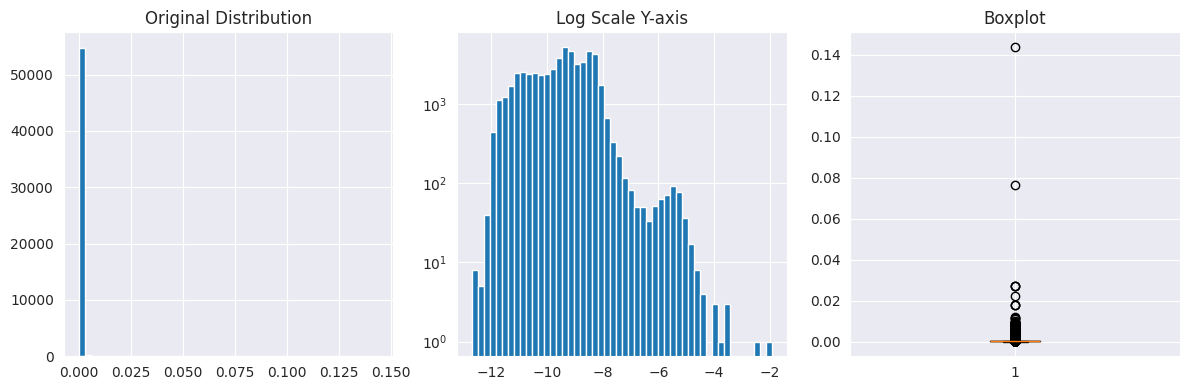

99th percentile: 0.001055
99.9th percentile: 0.006410


In [13]:
import matplotlib.pyplot as plt

# Visualize distribution
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(whole_y_train_basic, bins=50)
plt.title('Original Distribution')

plt.subplot(132)
plt.hist(np.log(whole_y_train_basic), bins=50)
plt.yscale('log')
plt.title('Log Scale Y-axis')

plt.subplot(133)
plt.boxplot(whole_y_train_basic)
plt.title('Boxplot')

plt.tight_layout()
plt.show()

# Check outliers
print(f"99th percentile: {np.percentile(whole_y_train_basic, 99):.6f}")
print(f"99.9th percentile: {np.percentile(whole_y_train_basic, 99.9):.6f}")

In [14]:
upper_limit = y_train_basic.quantile(0.99)
print(f"Clipping outliers at 99th percentile: {upper_limit:.6f}")
print(f"Original max: {y_train_basic.max():.6f}")
print(f"Values being clipped: {(y_train_basic > upper_limit).sum()} out of {len(y_train_basic)}")

Clipping outliers at 99th percentile: 0.001048
Original max: 0.143786
Values being clipped: 386 out of 38576


Save model to file and read it

In [15]:
import joblib


def save_model(model: lgb.LGBMRegressor, filename: str):
    if not os.path.exists("models"):
        os.mkdir("models")
    joblib.dump(model, os.path.join("models", filename))

def get_model(filename: str) -> lgb.LGBMRegressor:
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Brak zapisanego modelu o podanej nazwie {filename}")

    return joblib.load(filename)

def predict(model_name: str, x_test: np.typing.NDArray[np.float64]) -> np.typing.NDArray[np.float64]:
    if not os.path.exists(os.path.join("models", model_name)):
        raise FileNotFoundError(f"Brak zapisanego modelu o podanej nazwie {model_name}")

    model = get_model(model_name)
    return model.predict(x_test)

#### 1. LightGBM

In [17]:
y_train_clipped = y_train_basic.clip(upper=upper_limit)


def define_lgb(trial: optuna.Trial) -> lgb.LGBMRegressor:
    params = {
        # Regularyzacja
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 5, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 5, log=True),

        # Learning
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),

        # Tree structure
        "num_leaves": trial.suggest_int("num_leaves", 8, 48),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 80),

        # Sampling
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "subsample_freq": 1,

        # Quantile regression (mediana - odporna na outliery)
        "objective": "quantile",
        "alpha": 0.5,  # 0.5 = mediana

        "random_state": 42,
        "boosting": "gbdt",
        "n_jobs": -1,
        "verbose": -1,
    }
    return lgb.LGBMRegressor(**params)


def optimize_lightgbm_basic(trial: optuna.Trial):
    lightgbm = define_lgb(trial)
    groups = X_train_basic["model_name"]
    kf = GroupKFold(
        n_splits=len(np.unique(groups)),
        shuffle=True,
        random_state=42
    )

    scores = cross_val_score(
        lightgbm,
        X_train_basic,
        y_train_clipped,
        cv=kf,
        groups=groups,
        scoring='neg_root_mean_squared_error'
    )
    return scores.mean() * (-1)


study_lgb_basic = optuna.create_study(
    study_name="Optimize LGBM",
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
)

study_lgb_basic.optimize(optimize_lightgbm_basic, n_trials=50)

[I 2025-11-30 10:54:44,231] A new study created in memory with name: Optimize LGBM
[I 2025-11-30 10:54:48,864] Trial 0 finished with value: 0.0004541118724404316 and parameters: {'reg_alpha': 0.10253509690168493, 'reg_lambda': 3.6808608148776107, 'learning_rate': 0.07259248719561363, 'n_estimators': 340, 'num_leaves': 14, 'max_depth': 5, 'min_data_in_leaf': 14, 'subsample': 0.9464704583099741, 'colsample_bytree': 0.8404460046972835}. Best is trial 0 with value: 0.0004541118724404316.
[I 2025-11-30 10:54:53,122] Trial 1 finished with value: 0.00046110487102151457 and parameters: {'reg_alpha': 0.8148293210105289, 'reg_lambda': 0.01136467270001117, 'learning_rate': 0.13826189316223852, 'n_estimators': 433, 'num_leaves': 16, 'max_depth': 6, 'min_data_in_leaf': 23, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951}. Best is trial 0 with value: 0.0004541118724404316.
[I 2025-11-30 10:54:55,709] Trial 2 finished with value: 0.0004372856909960014 and parameters: {'reg_alp

#### KROK 3: Po optymalizacji, wytrenuj finalny model

In [18]:
# Finalny model z najlepszymi parametrami
best_params = study_lgb_basic.best_params
best_params.update({
    "random_state": 42,
    "objective": "quantile",
    "alpha": 0.5,
    "boosting": "gbdt",
    "n_jobs": -1,
    "verbose": -1,
})

final_model = lgb.LGBMRegressor(**best_params)
save_model(final_model, "final_model.pkl")
final_model.fit(X_train_basic, y_train_clipped)

,boosting_type,'gbdt'
,num_leaves,8
,max_depth,7
,learning_rate,0.01500193307886834
,n_estimators,175
,subsample_for_bin,200000
,objective,'quantile'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [19]:
print("\nBest parameters:", study_lgb_basic.best_params)


Best parameters: {'reg_alpha': 0.03763962823714688, 'reg_lambda': 0.20262671948465252, 'learning_rate': 0.01500193307886834, 'n_estimators': 175, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 54, 'subsample': 0.8448423032374535, 'colsample_bytree': 0.9989611392384947}


#### KROK 4: Predykcja i ewaluacja

In [20]:
predictions = final_model.predict(X_test_basic)

metrics = get_metrics(y_test_basic, predictions)

print("\n" + "="*50)
print("FINAL MODEL EVALUATION (on original test data)")
print("="*50)
print(f"MAE:  {metrics["mae"]:.6f} (relative: {metrics["mae"] / y_test_basic.mean():.2%})")
print(f"RMSE: {metrics["rmse"]:.6f}")
print(f"R²:   {metrics["r2"]:.4f}")
print(f"\nTest set mean: {y_test_basic.mean():.6f}")
print(f"Test set std:  {y_test_basic.std():.6f}")


FINAL MODEL EVALUATION (on original test data)
MAE:  0.000060 (relative: 38.18%)
RMSE: 0.000767
R²:   0.0261

Test set mean: 0.000156
Test set std:  0.000778


#### Analiza błędów na outlierach

In [21]:
errors = np.abs(y_test_basic - predictions)
outlier_mask = y_test_basic > upper_limit

test_metrics_without_outliers = get_metrics(y_test_basic[~outlier_mask], predictions[~outlier_mask])
test_metrics_with_outliers = get_metrics(y_test_basic[outlier_mask], predictions[outlier_mask])
test_metrics = get_metrics(y_test_basic, predictions)
print(f"\n{'Metric':<20} {'All Test':<15} {'Non-outliers':<15} {'Outliers':<15}")
print("-"*65)
print(f"{'Count':<20} {len(y_test_basic):<15} {(~outlier_mask).sum():<15} {outlier_mask.sum():<15}")
print(f"{'MAE':<20} {test_metrics["mae"]:.6f}       {test_metrics_without_outliers["mae"]:.6f}       {test_metrics_with_outliers["mae"]:.6f}")
print(f"{'RMSE':<20} {test_metrics["rmse"]:.6f}       {test_metrics_without_outliers["rmse"]:.6f}       {test_metrics_with_outliers["rmse"]:.6f}")
print(f"{'R²':<20} {test_metrics["r2"]:.4f}          {test_metrics_without_outliers["r2"]:.4f}          {test_metrics_with_outliers["r2"]:.4f}")


Metric               All Test        Non-outliers    Outliers       
-----------------------------------------------------------------
Count                16533           16366           167            
MAE                  0.000060       0.000017       0.004277
RMSE                 0.000767       0.000053       0.007616
R²                   0.0261          0.7514          -0.4538


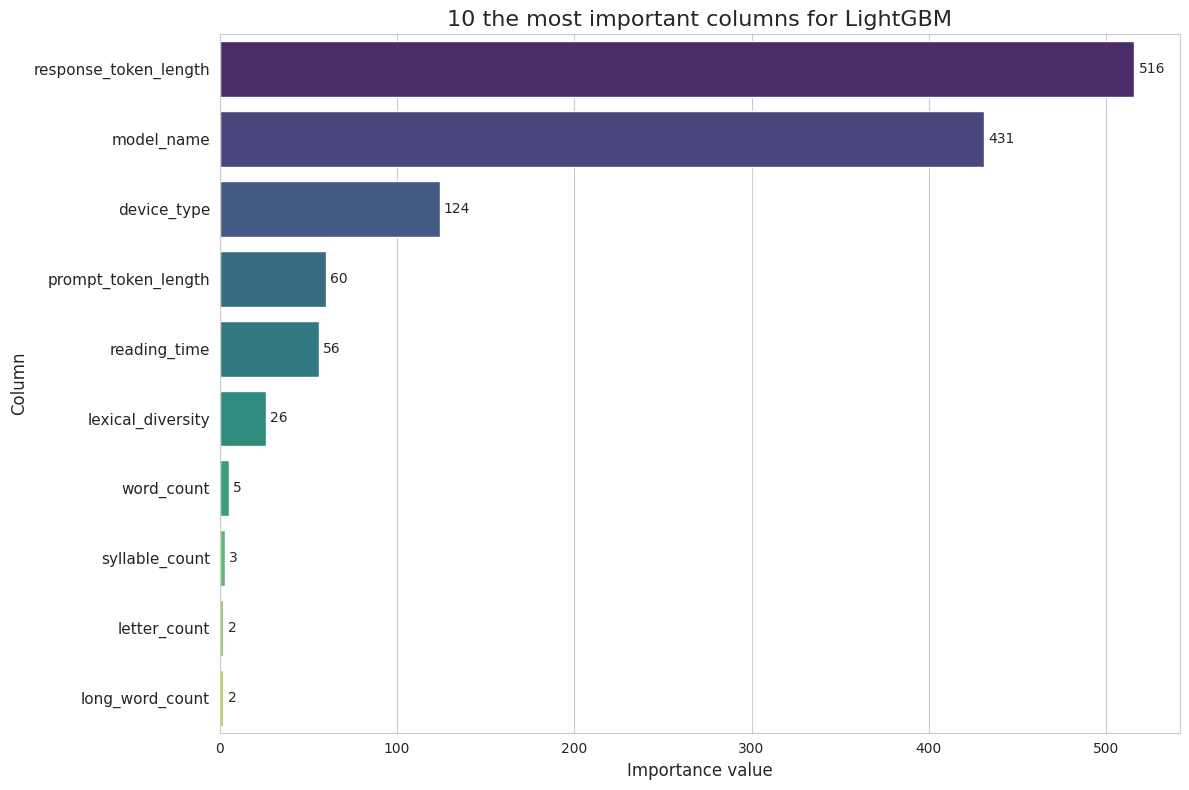

In [22]:
lightGBM_importance = pd.DataFrame({
    'feature': final_model.feature_name_,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')

ax = sns.barplot(
    data=lightGBM_importance,
    x='importance',
    y='feature',
    hue='feature',
    legend=False,
    palette='viridis'
)

for i in ax.containers:
    ax.bar_label(i, fmt='%g', label_type='edge', fontsize=10, padding=3)

plt.title('10 the most important columns for LightGBM', fontsize=16)
plt.xlabel('Importance value', fontsize=12)
plt.ylabel('Column', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

Learning curve

In [ ]:
from sklearn.model_selection import learning_curve


groups = X_train_basic["model_name"]
kf = GroupKFold(
    n_splits=len(np.unique(groups)),
    shuffle=True,
    random_state=42
)

train_sizes, train_scores, valid_scores = learning_curve(
    final_model,
    X_train_basic,
    y_train_clipped,
    cv=kf,
    groups=groups,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_scores = -train_scores
valid_scores = -valid_scores

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Train RMSE")
plt.plot(train_sizes, valid_scores.mean(axis=1), "o-", label="Valid RMSE")
plt.fill_between(train_sizes,
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.2)
plt.fill_between(train_sizes,
                 valid_scores.mean(axis=1) - valid_scores.std(axis=1),
                 valid_scores.mean(axis=1) + valid_scores.std(axis=1),
                 alpha=0.2)

plt.title("Learning Curve (RMSE)")
plt.xlabel("Training samples")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

#### <center>Optuna visualization</center>

In [ ]:
optuna.visualization.plot_optimization_history(study_lgb_basic)

In [ ]:
optuna.visualization.plot_slice(study_lgb_basic)

In [ ]:
optuna.visualization.plot_param_importances(study_lgb_basic)